[Pandas](https://pandas.pydata.org/) offers a powerful interface for data
manipulation and analysis, but the dataframe can be an opaque object that’s
hard to reason about in terms of its data types and other properties. Often
times you’ll have to manually inspect a dataframe at runtime to confirm its contents.
The careful reader may even be able to infer the datatypes of its columns by the kinds
of functions you apply to it, but at the cost of considerable cognitive overhead.

This problem is magnified in complex ETL pipelines that may involve many
transformations and joins, or collaborative contexts in which teams of data
scientists/engineers need to maintain pandas code in production. Even in
research or reporting settings, maintaining reproducible code can be a challenge
if the underlying dataset is corrupted or otherwise changed unexpectedly,
especially if the findings of an analysis leads to business-critical decisions.

[Pandera](https://github.com/cosmicBboy/pandera) is a validation toolkit to make
pandas data structures more transparent so it’s easier to reason about the
underlying schema of pandas data structures as they undergo various transformations.

In this post I’ll sketch out a situation that you may find yourself in where
using Pandera may save you and your team from a lot of headaches.

## Case Study: New York 311 Data

Suppose that you run a small data science shop, and one of your clients is the
New York mayor’s office. They’ve tasked you with creating monthly reports of
New York’s 311 calls containing insights about:

1. The most common complaints/descriptors by borough.
2. The proportion of service requests that are closed on or before the due date
   by responding agency.
3. The number of complaints per day by complaint type and borough.

For the purposes of this exercise, let’s assume that this dataset is
periodically updated on the official data portal. Every month you need to
generate a new report (an html file) with some plots showing the relevant
summary statistics.

## Dataset Quality Validation

The first thing we need to do is read the data into memory from
[nycopendata](https://nycopendata.socrata.com/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9).

In [1]:
import logging
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from collections import OrderedDict
from IPython.display import display, Markdown
from sodapy import Socrata

logging.disable(logging.WARNING)

# utility function to print python output as markdown snippets
def print_output(s):
    display(Markdown("```python\n{}\n```".format(s)))
    
%matplotlib inline

In [104]:
# define date range 
DATE_RANGE = ("2018/12/01", "2018/12/31")

client = Socrata("data.cityofnewyork.us", None)

# get data from the beginning of the month

df_311 = pd.DataFrame.from_records(
    client.get(
        "erm2-nwe9",
        # use socrata SoQL query clauses: https://dev.socrata.com/docs/queries/
        where="created_date >= '%s' and created_date <= '%s'" % DATE_RANGE))
df_311.head(3)

,address_type,agency,agency_name,bbl,borough,bridge_highway_direction,bridge_highway_name,bridge_highway_segment,city,closed_date,...,park_facility_name,resolution_action_updated_date,resolution_description,road_ramp,status,street_name,taxi_pick_up_location,unique_key,x_coordinate_state_plane,y_coordinate_state_plane
0,ADDRESS,NYPD,New York City Police Department,1004470036,MANHATTAN,NaN,NaN,NaN,NEW YORK,2018-12-01T02:06:00,...,Unspecified,2018-12-01T02:06:00,The Police Department responded to the complai...,NaN,Closed,EAST 5 STREET,NaN,41069627,987601,203900
1,ADDRESS,NYPD,New York City Police Department,3011630076,BROOKLYN,NaN,NaN,NaN,BROOKLYN,2018-12-01T04:45:58,...,Unspecified,2018-12-01T04:45:58,The Police Department responded to the complai...,NaN,Closed,PARK PLACE,NaN,41069628,995811,185024
2,ADDRESS,NYPD,New York City Police Department,2046730075,BRONX,NaN,NaN,NaN,BRONX,2018-12-01T11:49:18,...,Unspecified,2018-12-01T11:49:18,The Police Department issued a summons in resp...,NaN,Closed,EAST 215 STREET,NaN,41069671,1022979,259673


Simple enough!  We can see that each row in this dataset is a service request record containing
metadata about different aspects of the request, like which borough the call came from, and which
agency responded to the call.

One thing we can do to make this code more readable would be to
explicitly specify the columns we want to use, and what type we expect them to be.

In [107]:
# specify column names and types
usecols = OrderedDict([
    ("unique_key", str),
    ("borough", str),
    ("agency_name", str),
    ("created_date", "datetime64[ns]"),
    ("due_date", "datetime64[ns]"),
    ("closed_date", "datetime64[ns]"),
    ("complaint_type", str),
])
cols = list(usecols.keys())

# page through the results
MAX_PAGES = 500
LIMIT = 10000
records = []

print("fetching 311 data:")
for i in range(MAX_PAGES):
    results = client.get(
        "erm2-nwe9",
        select=",".join(cols),
        where="created_date >= '%s' and created_date <= '%s'" % DATE_RANGE,
        order="created_date",
        limit=LIMIT,
        offset=LIMIT * i)
    print(".", end="", flush=True)
    records.extend(results)
    if len(results) < LIMIT:
        break

        
df_311 = pd.DataFrame.from_records(records)[cols]
df_311 = df_311.astype(usecols)
display(df_311.head(3))

fetching 311 data:
.................

,unique_key,borough,agency_name,created_date,due_date,closed_date,complaint_type
0,41072528,QUEENS,Department of Health and Mental Hygiene,2018-12-01,2018-12-31 01:59:50,2018-12-07,Unsanitary Animal Pvt Property
1,41073153,QUEENS,Department of Health and Mental Hygiene,2018-12-01,2018-12-31 00:29:24,2018-12-07,Rodent
2,41078328,MANHATTAN,Department of Health and Mental Hygiene,2018-12-01,2018-12-31 09:20:35,2018-10-17,Rodent


Wait, but we can do even better! Based on the project requirements and what we know about 
these data either by reading the [documentation](https://dev.socrata.com/foundry/data.cityofnewyork.us/fhrw-4uyv) or doing some 
exploratory data analysis, we can make some stricter assertions
about them. We can do this very simply with `pandera`.

### Defining a DataFrameSchema

Beyond the column presence and data type checks, we can make assertions about
the properties that the dataset must have in order to be considered valid.

We first define a `DataFrameSchema`, feeding it a dictionary where keys are
column names and values are `Column` objects, which are initialized with the
data type of the column and a `Check` or a list of `Check`s.

In [108]:
from pandera import DataFrameSchema, Check, Column, Index, Bool, \
    DateTime, Float, Int, String

schema = DataFrameSchema({
    "column1": Column(String),
    "column2": Column(Int, Check(lambda x: x > 0)),
    "column3": Column(Float, [
        Check(lambda x: x > 0.),
        Check(lambda s: s.mean() > 0.5, element_wise=False)])
})

A `Check` takes a function as an argument with the signature `x -> Bool`
where `x` is a particular value in the column. In the code below you can
see that the `status` and `borough` column checks assert that all the values in
the column are in a pre-specified set of categories.

```python
Check(lambda x: x in ["category_1", "category_2"]);
```

You can create vectorized checks by specifying `element_wise=False` (`True` by default), which
changes the expected function signature to `s -> Bool|Series[Bool]`, where `s` is a pandas 
`Series` and the return value can either be `Bool` or a boolean `Series`.

```python
# the checking function resolves to a boolean
Check(lambda s: s.mean() > 0.5, element_wise=False);

# the checking function can also resolve to a boolean Series
Check(lambda s: s > 0, element_wise=False);
```

For human-friendly error messages, you can also supply an `error` argument with the message 
to raise if the check fails. We can check this functionality out with a `SeriesSchema`, which
has a similar API to the `DataFrameSchema`.

In [109]:
from pandera import SeriesSchema

s = pd.Series([1, 1, 2, 3])
series_schema = SeriesSchema(
    Int, Check(lambda s: s.duplicated().sum() == 0, element_wise=False,
        error="failed uniqueness check"))

try:
    series_schema.validate(s)
except Exception as e:
    print_output(e)

```python
series did not pass series validator 0: <lambda>: failed uniqueness check
```

Multiple columns can also use the same `Check` objects. In the code snippet
below I've defined a `date_min_check` object that are used to verify the
`due_date`, and `closed_date` columns, along with the `df_311_schema` that
specifies the schema for the 311 data.

In [110]:
# define a date range checker
date_range_check = Check(
    lambda s: (s >= pd.Timestamp(DATE_RANGE[0])) &
              (s <= pd.Timestamp(DATE_RANGE[1])),
    element_wise=False)

date_min_check = Check(
    lambda s: s >= pd.Timestamp(DATE_RANGE[0]),
    element_wise=False)
                   
BOROUGHS = [
    "BROOKLYN",
    "QUEENS",
    "BRONX",
    "MANHATTAN",
    "STATEN ISLAND",
    "Unspecified"]
    
# constructing a schema should feel familiar for pandas users
df_311_schema = DataFrameSchema({
    # make sure unique_key is unique
    "unique_key": Column(String, Check(lambda s: s.duplicated().sum() == 0,
                                       element_wise=False,
                                       error="column is not unique")),
    # assert borough column contain proper values
    "borough": Column(String, Check(lambda x: x in BOROUGHS,
                                    error="borough check failed")),
    "agency_name": Column(String),
    # assert that records are within the date range
    "created_date": Column(DateTime, date_range_check),
    "due_date": Column(DateTime, date_min_check, nullable=True),
    "closed_date": Column(DateTime, date_min_check, nullable=True),
    "complaint_type": Column(String),
})

Once we've defined the `DataFrameSchema`, we can use it to verify the data.
I usually take this opportunity to create a preprocessing function that does some basic
filtering/transformations. In this case I'm going to assume that records with
`closed_date < created_date` are malformed data. There may some good reason the data is
this way, but for now so I'll be removing them from the analysis. 

In [111]:
def preprocess_data(df):
    # remove records where closed_date occurs before created_date
    df = df[~(df.closed_date < df.created_date)]
    return df

preprocessed_df_311 = df_311_schema.validate(preprocess_data(df_311))

With a `DataFrameSchema`, not only can we see what to expect from
our input data, `pandera` also verifies that they fulfill these expectations
at runtime.

Suppose that for some unknown reason these data are corrupted at a future date.
`pandera` gives us useful error messages based on whether a column is missing, a
column has the incorrect data type, or whether a `Check` assertion failed.

For example, if some of the `created_date` values somehow fell out of the expected date
range due to a datetime parsing error, we receive a useful error message.

In [16]:
df_311_corrupt = df_311.copy()

df_311_corrupt["created_date"].iloc[:5] = df_311_corrupt[
    "created_date"].head(5) - pd.Timedelta(weeks=10)

try:
    df_311_schema.validate(df_311_corrupt)
except Exception as e:
    print_output(e.code)

```python
<Schema Column: type=datetime64[ns]> failed element-wise validator 0:
<lambda>
failure cases: {0: Timestamp('2018-09-22 00:00:00'), 1: Timestamp('2018-09-22 00:00:00'), 2: Timestamp('2018-09-22 00:00:00'), 3: Timestamp('2018-09-22 00:00:00'), 4: Timestamp('2018-09-22 00:00:00')}
```

Or if a column isn't the expected type.

In [17]:
df_311_corrupt = df_311.copy().assign(
    unique_key=df_311.unique_key.astype(int))

try:
    df_311_schema.validate(df_311_corrupt)
except Exception as e:
    print_output(e.code)

```python
expected series 'unique_key' to have type object, got int64
```

Or if the column is somehow not present in the dataframe.

In [18]:
df_311_corrupt = df_311.copy().drop("complaint_type", axis=1)

try:
    df_311_schema.validate(df_311_corrupt)
except Exception as e:
    print_output(e.code)

```python
column 'complaint_type' not in dataframe
  unique_key    borough                              agency_name created_date  \
0   41072528     QUEENS  Department of Health and Mental Hygiene   2018-12-01   
1   41073153     QUEENS  Department of Health and Mental Hygiene   2018-12-01   
2   41078328  MANHATTAN  Department of Health and Mental Hygiene   2018-12-01   
3   41078347     QUEENS  Department of Health and Mental Hygiene   2018-12-01   
4   41078591   BROOKLYN  Department of Health and Mental Hygiene   2018-12-01   

             due_date closed_date  
0 2018-12-31 01:59:50  2018-12-07  
1 2018-12-31 00:29:24  2018-12-07  
2 2018-12-31 09:20:35  2018-10-17  
3 2018-12-31 13:51:12  2018-12-05  
4 2018-12-31 10:54:26  2018-12-04  
```

Note that calling `schema.validate(df)` will return the validated dataframe,
so you would be able to easily refactor an existing function to perform schema
validation:

In [19]:
def processing_function(df):
    # do something
    ...
    return processed_df


def processing_function(df):
    # do something
    ...
    # validate the output
    return schema.validate(processed_df)


def processing_function(df):
    # validate the input
    df = schema.validate(df)
    # do something
    ...
    return processed_df

## Adding Guardrails around your Data Munging Pipeline

To obtain the three insights that we need to create our monthly report, we need
to manipulate the data. There's no single workflow for adding guard rails around your
data manipulation code, but a good rule of thumb is to compose a sequence of functions
together to do it. We can then use these functions as scaffolding to verify the 
dataframe inputs/outputs of a function before they’re passed onto the next one.

First we clean up the `complaint_type` column in order to address the first
question:

> 1. The most common complaints by borough.

In this case we'll be re-mapping a few of the values in the `complaint_type` column
and then validating the output of the function with a `DataFrameSchema`.

In [20]:
REPLACE_DICT = {
    "Noise - Residential": "Noise",
    "Noise - Street/Sidewalk": "Noise",
    "Noise - Commercial": "Noise",
    "Noise - Park": "Noise",
    "Noise - Helicopter": "Noise",
    "Noise - Vehicle": "Noise",
}

clean_complaint_schema = DataFrameSchema({
    "complaint_type_clean": Column(String, [
        Check(lambda x: x not in REPLACE_DICT),
        Check(lambda s: (s == "Noise").any(), element_wise=False)
    ])
})


def clean_complaint_type(df):
    clean_df = (
        df.assign(complaint_type_clean=df.complaint_type)
        .replace({"complaint_type_clean": REPLACE_DICT})
    )
    return clean_complaint_schema.validate(clean_df)
    
    
clean_complaint_type(df_311).head(3)

,unique_key,borough,agency_name,created_date,due_date,closed_date,complaint_type,complaint_type_clean
0,41072528,QUEENS,Department of Health and Mental Hygiene,2018-12-01,2018-12-31 01:59:50,2018-12-07,Unsanitary Animal Pvt Property,Unsanitary Animal Pvt Property
1,41073153,QUEENS,Department of Health and Mental Hygiene,2018-12-01,2018-12-31 00:29:24,2018-12-07,Rodent,Rodent
2,41078328,MANHATTAN,Department of Health and Mental Hygiene,2018-12-01,2018-12-31 09:20:35,2018-10-17,Rodent,Rodent


Next, we create a new column `closed_lte_due` which is a boolean column
where `True` indicates that the service request was closed before or at
the `due_date`. We'll need this derived data when answering the second question:

> 2. The proportion of service requests that are closed on or before the due date
  by responding agency.
  
In this case, we'll use the `check_output` decorator as a convenience to validate
the output of the function (which is assumed to be a dataframe).

In [21]:
from pandera import check_output


@check_output(DataFrameSchema({"closed_lte_due": Column(Bool, nullable=True)}))
def add_closed_lte_due(df):
    return df.assign(
        closed_lte_due=(
            (df.closed_date <= df.due_date)
            .where(df.due_date.notnull(), pd.NaT))
    )


add_closed_lte_due(df_311).head(3)

,unique_key,borough,agency_name,created_date,due_date,closed_date,complaint_type,closed_lte_due
0,41072528,QUEENS,Department of Health and Mental Hygiene,2018-12-01,2018-12-31 01:59:50,2018-12-07,Unsanitary Animal Pvt Property,True
1,41073153,QUEENS,Department of Health and Mental Hygiene,2018-12-01,2018-12-31 00:29:24,2018-12-07,Rodent,True
2,41078328,MANHATTAN,Department of Health and Mental Hygiene,2018-12-01,2018-12-31 09:20:35,2018-10-17,Rodent,True


**Usage Note:**

You can specify where the dataframe is in the output structure, where the
default assumes a single dataframe as an output.

```python
@check_output(schema)
def my_function(df):
    # do stuff
    return df
```

Or supply an integer, indexing where the dataframe is in a tuple output.

```python
@check_output(schema, 2)
def my_function(df):
    ...
    return x, y, df
```

And for more complex outputs, supply a lambda function to specify how to
pull the dataframe from python objects.

```python
@check_output(schema, lambda out: out[2]["df_key"])
def my_function(df):
    ...
    return x, y, {"df_key": df}
```

Finally, we clean up the `created_date` column and create a new column
`created_date_clean` with the format `YYYY-MM-DD`. We'll need this in order
to count up the number of records created per day for the last question:

> 3. Number of complaints recorded per day by complaint type and borough.

For this last function, we'll be validating both the inputs and outputs of
our function with `check_input` and `check_output`, respectively. Checking
the input is probably not necessary at this point, but it just illustrates
how one can define validation points at the input or output level.

In [22]:
from pandera import check_input


@check_input(DataFrameSchema({"created_date": Column(DateTime)}))
@check_output(DataFrameSchema({"created_date_clean": Column(DateTime)}))
def clean_created_date(df):
    return (
        df.assign(created_date_clean=(
            df.created_date
            .dt.strftime("'%Y-%m-%d")
            .astype("datetime64[ns]")))
)

clean_created_date(df_311).head(3)

,unique_key,borough,agency_name,created_date,due_date,closed_date,complaint_type,created_date_clean
0,41072528,QUEENS,Department of Health and Mental Hygiene,2018-12-01,2018-12-31 01:59:50,2018-12-07,Unsanitary Animal Pvt Property,2018-12-01
1,41073153,QUEENS,Department of Health and Mental Hygiene,2018-12-01,2018-12-31 00:29:24,2018-12-07,Rodent,2018-12-01
2,41078328,MANHATTAN,Department of Health and Mental Hygiene,2018-12-01,2018-12-31 09:20:35,2018-10-17,Rodent,2018-12-01


**Usage Note:**

Using `@check_input`, you can specify which positional or key-word argument
references the dataframe, where the default assumes the first argument is the
dataframe/series to check.

```python
@check_input(schema, 1)
def my_function(x, dataframe):
    ...
    
@check_input(schema, "dataframe")
def my_function(x, dataframe):
    ...
```

Now we can pipe these functions in sequence to obtain our cleaned data.

In [23]:
clean_df_311 = (
    df_311
    .pipe(clean_complaint_type)
    .pipe(add_closed_lte_due)
    .pipe(clean_created_date))

## Reproducible Reports: Validate Analysis and Plotting Code

Now that we have all the derived data we need to produce our report, we can now
compute summary statistics and create plots for the final product.

Here it’s useful to think of our data manipulation code as the “backend” data
and our insight-generating code as the “frontend” data.

So at this point we need to reshape our “backend” data into the appropriate
aggregated form that can be easily plotted. Here `pandera` can help by
clarifying what our aggregation and plotting functions can expect.

### Count of the Most Common Complaints by Borough

First we select records belonging to the top 12 complaint types and
count them up by `borough` and `complaint_type_clean`. These aggregated
data can then be used to produce a plot of the `count` of complaints in
the last quarter vs. `borough`, faceted by `complaint_type_clean`.

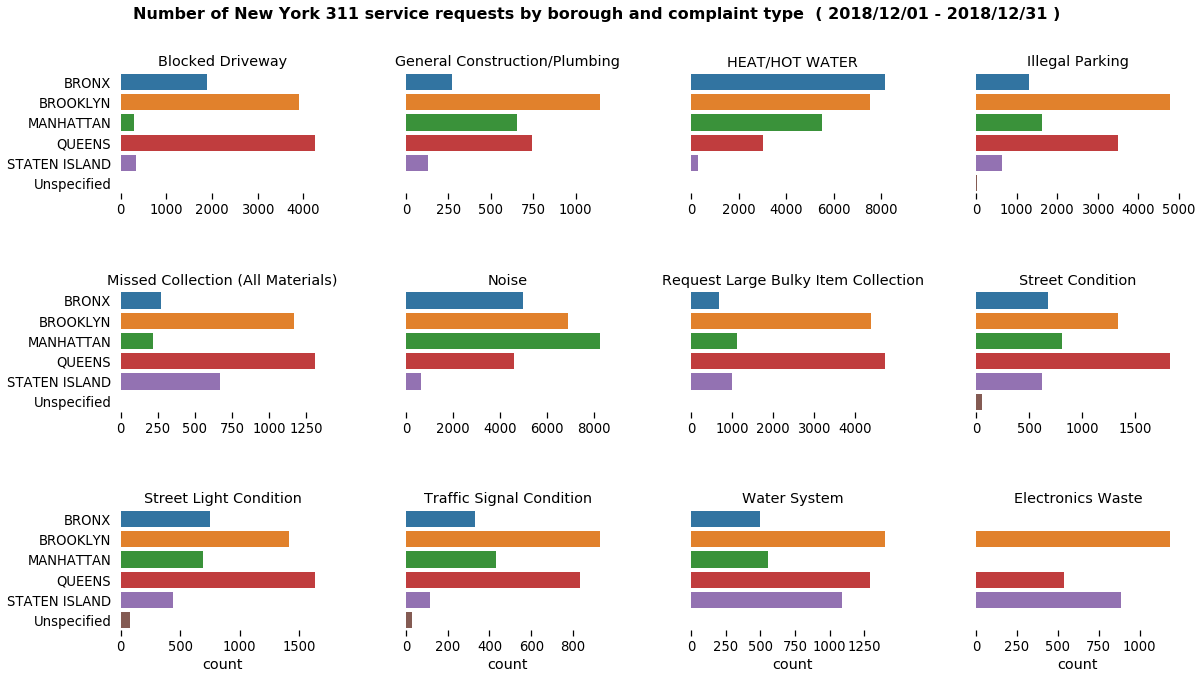

In [115]:
complaint_by_borough_schema = DataFrameSchema({
    "borough": Column(String),
    "complaint_type_clean": Column(String),
    # make sure count column contains positive integers
    "count": Column(Int, Check(lambda x: x > 0)),
})

TOP_N = 12
COMPLAINT_TYPE_TITLE = \
    "%s  ( %s - %s )" % (
        "Number of New York 311 service requests by borough and complaint type",
        DATE_RANGE[0], DATE_RANGE[1])

@check_output(complaint_by_borough_schema)
def agg_complaint_types_by_borough(clean_df):
    plot_df = (
        clean_df
        .groupby(["borough", "complaint_type_clean"])
        .unique_key.count()
        .rename("count")
        .reset_index())
    # select only the top 12 complaint types (across all boroughs)
    top_complaints = (
        clean_df.complaint_type_clean
        .value_counts()
        .sort_values(ascending=False)
        .head(TOP_N).index.tolist())
    return plot_df[plot_df.complaint_type_clean.isin(top_complaints)]


# this is probably overkill, but this illustrates that you can
# add schema checks at the interface of two functions.
@check_input(complaint_by_borough_schema)
def plot_complaint_types_by_borough(complaint_by_borough_df):
    g = sns.catplot(
        x="count", y="borough",
        col="complaint_type_clean",
        col_wrap=4,
        data=complaint_by_borough_df,
        kind="bar",
        height=3,
        aspect=1.4,
        sharex=False,
    )
    g.set_titles(template="{col_name}")
    g.set_ylabels("")
    g.fig.suptitle(COMPLAINT_TYPE_TITLE, y=1.05, fontweight="bold", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.8, wspace=0.4)
    sns.despine(left=True, bottom=True)
    for ax in g.axes.ravel():
        ax.tick_params(left=False)
    return g

with sns.plotting_context(context="notebook", font_scale=1.2):
    g = agg_complaint_types_by_borough(clean_df_311).pipe(
        plot_complaint_types_by_borough)

### Proportion of Service Requests Closed on or Before the Due Date

For this question we'll compute the proportion of requests that were closed
on or before the `due_date` by `agency_name`, where we'll remove entries
that have null values or where the proportion is `0`.

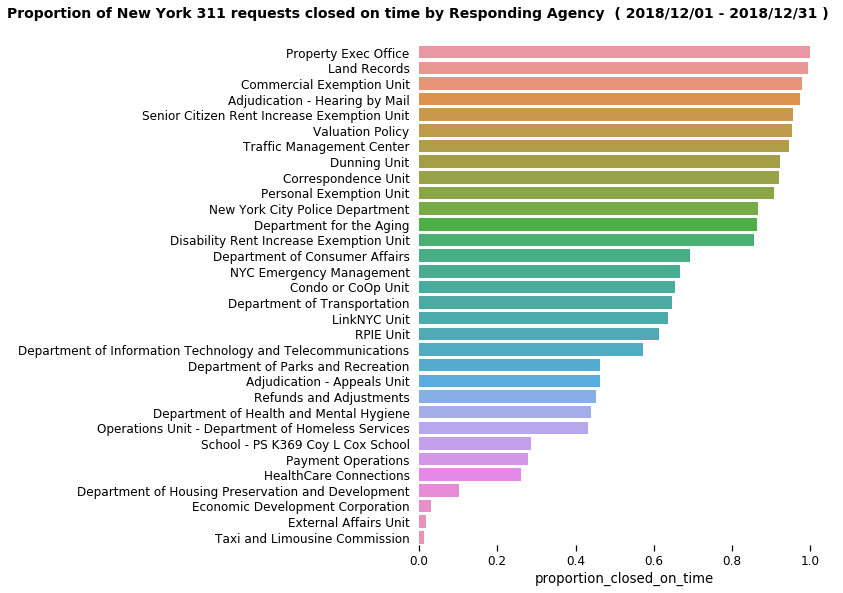

In [116]:
proportion_by_agency_schema = DataFrameSchema({
    "agency_name": Column(String),
    "proportion_closed_on_time": Column(
        Float, Check(lambda x: 0 <= x <= 1), nullable=True)
})

PROPORTION_BY_AGENCY_TITLE = \
    "%s  ( %s - %s )" % (
        "Proportion of New York 311 requests closed on time by Responding Agency",
        DATE_RANGE[0], DATE_RANGE[1])

@check_output(proportion_by_agency_schema)
def agg_proportion_by_agency(clean_df):
    return (
        clean_df.groupby("agency_name")
        .closed_lte_due.apply(lambda s: s.mean() if s.count() > 0 else np.nan)
        .dropna()
        .rename("proportion_closed_on_time")
        .reset_index("agency_name")
        .query("proportion_closed_on_time > 0")
    )
    

@check_input(proportion_by_agency_schema)
def plot_proportion_by_agency(proportion_by_agency_df):
    g = sns.catplot(
        x="proportion_closed_on_time", y="agency_name",
        order=proportion_by_agency_df.sort_values(
            "proportion_closed_on_time", ascending=False).agency_name,
        data=proportion_by_agency_df,
        kind="bar",
        height=8,
        aspect=1.5)
    sns.despine(left=True, bottom=True)
    g.set_ylabels("")
    for ax in g.axes.ravel():
        ax.tick_params(left=False)
    g.fig.suptitle(PROPORTION_BY_AGENCY_TITLE, y=1.03, fontweight="bold", fontsize=14)
    return g

with sns.plotting_context(context="notebook", font_scale=1.1):
    axes = plot_proportion_by_agency(agg_proportion_by_agency(clean_df_311))


### Daily Complaints per Borough

Here we have to count up all number of service requests per day by `borough`,
so we'll want to make sure that the `number_of_complaints` is a positive number
and that the borough values are in the `BOROUGHS` global variable that we defined
earlier.

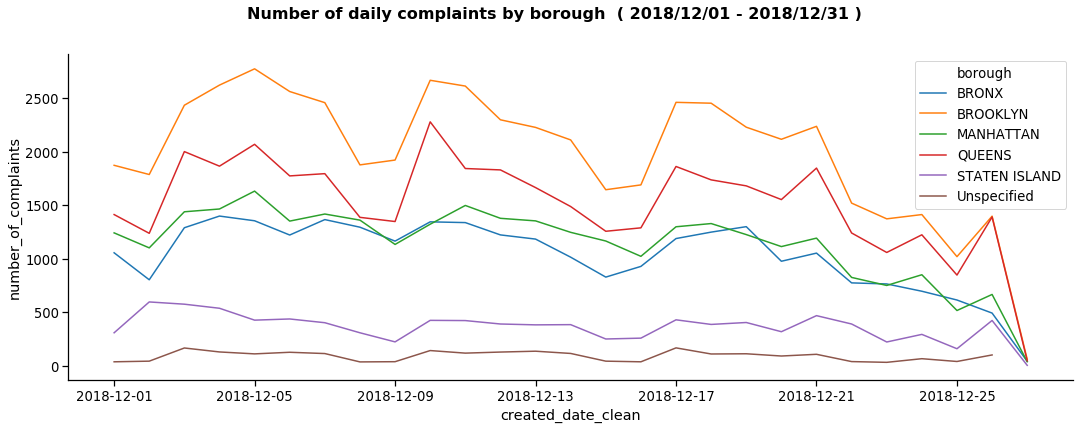

In [117]:
daily_complaints_schema = DataFrameSchema({
    "created_date_clean": Column(DateTime, Check(lambda x: x >= pd.Timestamp(DATE_RANGE[0]))),
    "borough": Column(String, Check(lambda x: x in BOROUGHS)),
    "number_of_complaints": Column(Int, Check(lambda x: x > 0)),
})

DAILY_COMPLAINTS_TITLE = \
    "%s  ( %s - %s )" % (
        "Number of daily complaints by borough",
        DATE_RANGE[0], DATE_RANGE[1])


@check_output(daily_complaints_schema)
def agg_daily_complaints(clean_df):
    return (
        clean_df.groupby(["borough", "created_date_clean"])
        .unique_key.count().rename("number_of_complaints")
        .reset_index())


@check_input(daily_complaints_schema)
def plot_daily_complaints(daily_complaints_df):
    fig, ax = plt.subplots(1, figsize=(18, 6))
    ax = sns.lineplot(
        x="created_date_clean", y="number_of_complaints", hue="borough",
        data=daily_complaints_df, ax=ax)
    sns.despine()
    fig.suptitle(DAILY_COMPLAINTS_TITLE, y=0.99, fontweight="bold", fontsize=16)
    return ax

with sns.plotting_context(context="notebook", font_scale=1.2):
    plot_daily_complaints(agg_daily_complaints(clean_df_311))

## Conclusion

And there you have it! Once you know your data well enough to express the contents
of a dataframe as a schema of columns, data types, and checks, your code can be
more easily reviewed, debugged, and maintained by you and your team.

What this post doesn't really illustrate is the process of getting to know your data,
which is highly context dependent. In this case, I used the same jupyter notebook
that I used to create this post as a scratch-pad for inspecting the data and figuring
out exactly what I needed it to look like in order to answer the questions in my fictional
example using NYC 311 data.

I’m actively developing [`pandera`](https://github.com/cosmicBboy/pandera), with some
useful features coming down the road, like built-in hypothesis testing, multi-column
validation, and multi-index column and index validation.

On a personal note, I’ve found that it takes a little more discipline to add these
validation checks to my code, but I’m already seeing the benefits of doing so in my 
professional and side-project code. Thanks for reading, and feel free to try `pandera` out!